In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from dhdrnet.util import DATA_DIR, ROOT_DIR

plt.rcParams.update({'font.size': 14})
plt.rcParams.update({'axes.labelsize': 18})

figdir = ROOT_DIR / "figures"

In [7]:
df = (
    pd.read_csv(ROOT_DIR / "precomputed_data" / "store_2020-10-27.csv", index_col=0)
    .drop(columns="ev1")
    .rename(columns={"ev2": "ev"})
)
names = pd.read_csv(ROOT_DIR / "precomputed_data" / "test_current.csv")
df = df[df["name"].isin(names["names"])]
df = df.drop_duplicates()
df

,ev,name,metric,score
1584,-3.00,5066_20160724_121618_110,rmse,16.201134
1585,-3.00,5066_20160724_121618_110,psnr,23.939895
1586,-3.00,5066_20160724_121618_110,ssim,0.965922
1587,-3.00,5066_20160724_121618_110,perceptual,0.047302
1588,-2.75,5066_20160724_121618_110,rmse,16.540948
...,...,...,...,...
523723,5.75,0043_20160923_122514_781,perceptual,0.148934
523724,6.00,0043_20160923_122514_781,rmse,35.136912
523725,6.00,0043_20160923_122514_781,psnr,17.215532
523726,6.00,0043_20160923_122514_781,ssim,0.877194


In [8]:
grouped = df.set_index("name").groupby(["metric"])
grouped.describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.152325,0.112680
psnr,18.004786,5.801761
rmse,39.081830,23.139358
ssim,0.769130,0.231517


In [9]:
idxmins = (
    df[(df["metric"] == "perceptual") | (df["metric"] == "rmse")]
    .groupby(["name", "metric"])["score"]
    .idxmin()
)
best_scores_min = df.loc[idxmins]
best_scores_min
# this is the minimum score for each metric for each image
# unfortunately we want min for mse and perceptual
# and maxes for psnr, ssim

,ev,name,metric,score
188143,2.00,0006_20160721_170707_736,perceptual,0.031581
188168,3.75,0006_20160721_170707_736,rmse,11.903806
286935,2.50,0006_20160721_175239_909,perceptual,0.058179
286956,4.00,0006_20160721_175239_909,rmse,9.563386
377243,3.75,0006_20160721_181525_062,perceptual,0.049348
...,...,...,...,...
413372,3.00,c483_20150901_195108_436,rmse,19.015955
71359,2.00,c483_20150901_214630_530,perceptual,0.059056
71380,3.50,c483_20150901_214630_530,rmse,8.471777
71967,4.00,c483_20150901_221141_886,perceptual,0.043705


In [10]:
idxmaxs = (
    df[(df["metric"] == "psnr") | (df["metric"] == "ssim")]
    .groupby(["name", "metric"])["score"]
    .idxmax()
)
best_scores_max = df.loc[idxmaxs]
best_scores_max

,ev,name,metric,score
188169,3.75,0006_20160721_170707_736,psnr,26.617087
188142,2.00,0006_20160721_170707_736,ssim,0.975438
286957,4.00,0006_20160721_175239_909,psnr,28.518569
286958,4.00,0006_20160721_175239_909,ssim,0.965298
377245,4.00,0006_20160721_181525_062,psnr,26.302924
...,...,...,...,...
413374,3.00,c483_20150901_195108_436,ssim,0.971811
71381,3.50,c483_20150901_214630_530,psnr,29.571314
71386,3.75,c483_20150901_214630_530,ssim,0.970954
71957,3.50,c483_20150901_221141_886,psnr,31.740585


In [11]:
best_scores_df = pd.concat([best_scores_min, best_scores_max])
oracle = best_scores_df.groupby(["metric"]).describe()["score"][["mean", "std"]]
oracle

,mean,std
metric,,
perceptual,0.037905,0.024077
psnr,29.075697,5.774687
rmse,10.717247,5.932719
ssim,0.973383,0.014968


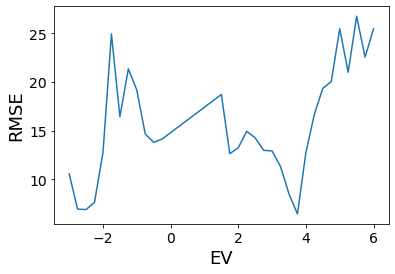

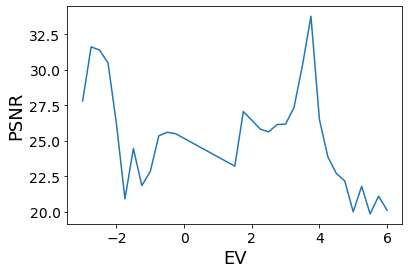

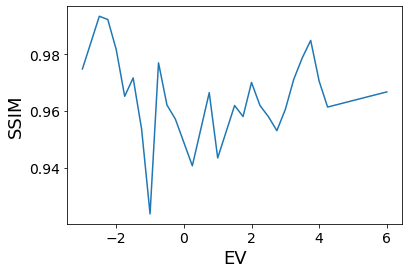

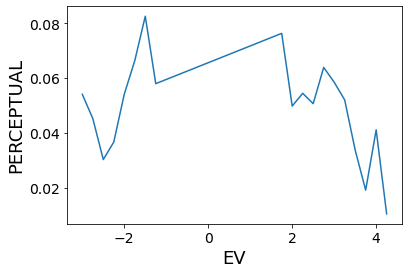

In [12]:
oracle_by_ev = best_scores_df.groupby(["metric", "ev"]).describe()["score"]

for metric in ["rmse", "psnr", "ssim", "perceptual"]:
    plt.plot(
        oracle_by_ev["mean"][metric].index,
        oracle_by_ev["mean"][metric],
    )
    plt.xlabel("EV")
    plt.ylabel(metric.upper())
    plt.savefig(figdir / f"{metric.upper()}_best_scores.pdf", pad_inches=0)
    plt.show()

In [13]:
df.loc[df["ev"] == 3.5].groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.055462,0.038827
psnr,26.724160,5.663801
rmse,14.507083,10.176345
ssim,0.961232,0.023200


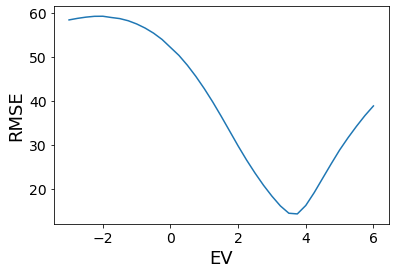

<Figure size 432x288 with 0 Axes>

In [14]:
df_by_metric = df.groupby(["metric", "ev"]).describe()["score"]
plt.plot(
    df_by_metric["mean"]["rmse"].index,
    df_by_metric["mean"]["rmse"],
    #     s=0.2 * df_by_metric["std"]["rmse"] ** 2,
)
plt.xlabel("EV")
plt.ylabel("RMSE")
plt.show()
plt.savefig(figdir / "RMSE_by_ev.pdf")

In [15]:
df.loc[df["ev"] == 3.5].groupby("metric").describe()["score"][["mean", "std"]].to_latex(
    figdir / "fixed_choice.tex"
)

In [16]:
cdf = pd.read_csv(
    ROOT_DIR / "precomputed_data" / "store_updown_2020-10-26.csv"
).drop_duplicates()
cdf.loc[cdf["metric"] == "rmse", "score"] = cdf.loc[
    cdf["metric"] == "rmse", "score"
].apply(np.sqrt)

cdf

,name,metric,ev,score
0,0030_20151008_105249_589,rmse,1,39.161667
1,0030_20151008_105249_589,psnr,1,16.273580
2,0030_20151008_105249_589,ssim,1,0.812035
3,0030_20151008_105249_589,rmse,2,25.583744
4,0030_20151008_105249_589,psnr,2,19.971522
...,...,...,...,...
10855,0043_20160923_122514_781,psnr,4,19.521871
10856,0043_20160923_122514_781,ssim,4,0.928805
10857,0043_20160923_122514_781,rmse,5,30.929737
10858,0043_20160923_122514_781,psnr,5,18.323279


In [17]:
cdf.groupby(["ev", "metric"]).describe()["score"][["mean", "std"]].to_latex(
    figdir / "conv_choice.tex"
)
cdf.groupby(["ev", "metric"]).describe()["score"][["mean", "std"]]

mean        std
ev metric                      
1  psnr    16.144820   4.237501
   rmse    44.319712  19.385214
   ssim     0.707827   0.226675
2  psnr    20.877057   5.383900
   rmse    27.334192  14.555937
   ssim     0.848401   0.141950
3  psnr    25.248919   3.031392
   rmse    14.784704   5.051738
   ssim     0.943758   0.033221
4  psnr    26.384000   3.998241
   rmse    13.644772   7.042175
   ssim     0.967228   0.020001
5  psnr    19.700461   3.322998
   rmse    28.345435  10.790692
   ssim     0.880723   0.058906

In [18]:
def parse_preds(pred_str):
    splits = pred_str.split(" ")
    return [float(s) for s in splits[1:-1] if len(s) > 0]


model_name = "mobile"
model_df = pd.read_csv(
    ROOT_DIR / "precomputed_data" / f"{model_name}_preds.csv", index_col=0
)
model_df["pred"] = model_df["pred"].apply(parse_preds)
model_df

,name,pred
0,0006_20160721_170707_736,"[3.5, 3.0, 3.25, 4.0, 2.75, 2.5, 2.0, 2.25]"
1,0006_20160721_175239_909,"[3.5, 4.0, 3.25, 3.0, 4.25, 2.75, 2.5, 2.0, 4.5]"
2,0006_20160721_181525_062,"[4.0, 3.75, 4.25, 3.5, 4.5, 3.25, 4.75, 3.0, -..."
3,0006_20160722_100126_028,"[3.5, 3.75, 3.25, 2.75, 2.5, 4.0, 2.0, 2.25]"
4,0006_20160722_100951_201,"[-0.5, -0.75, -1.0, 3.0, 3.5, 4.25, 3.25, 5.0]"
...,...,...
719,c483_20150901_173210_443,"[-1.0, 4.25, -0.75, -0.25, 4.0, 4.5, 3.75, 3.5..."
720,c483_20150901_194029_165,"[4.0, 4.25, 3.75, 4.5, 3.5, 3.25, 4.75, -1.0, ..."
721,c483_20150901_195108_436,"[4.0, 4.25, 4.5, 5.0, 3.0, 3.25, 3.75, 3.5]"
722,c483_20150901_214630_530,"[3.25, 2.75, 2.5, 3.5, 3.75, 2.0, 2.25, 1.75, ..."


In [15]:
from dhdrnet.util import get_pred, get_scores_for_preds, get_topk_score_df

In [16]:
# joined = df.set_index("name").join(model_df.set_index("name"))
# joined.iloc[0]
df.iloc[0]

ev                              -3
name      5066_20160724_121618_110
metric                        rmse
score                      16.2011
Name: 1584, dtype: object

In [17]:
model_df.iloc[0]

name                       0006_20160721_170707_736
pred    [3.5, 3.0, 3.25, 4.0, 2.75, 2.5, 2.0, 2.25]
Name: 0, dtype: object

In [18]:
t = get_scores_for_preds(model_df, df)
t.groupby("metric").describe()["score"]  # These are the top-10 accuracies

,count,mean,std,min,25%,50%,75%,max
metric,,,,,,,,
perceptual,6598.0,0.099130,0.088411,0.001936,0.048332,0.072065,0.110197,0.606988
psnr,6598.0,22.147233,5.255509,7.179987,19.052555,22.789929,25.997854,39.349285
rmse,6598.0,24.328786,17.873371,2.748375,12.783432,18.494549,28.438879,111.568304
ssim,6598.0,0.870288,0.183739,0.063669,0.885620,0.946782,0.964426,0.996701


In [19]:
r = get_topk_score_df(t, k=1)
r

,ev,name,metric,score
188143,2.00,0006_20160721_170707_736,perceptual,0.031581
188172,4.00,0006_20160721_170707_736,rmse,12.438333
286935,2.50,0006_20160721_175239_909,perceptual,0.058179
286956,4.00,0006_20160721_175239_909,rmse,9.563386
377243,3.75,0006_20160721_181525_062,perceptual,0.049348
...,...,...,...,...
413374,3.00,c483_20150901_195108_436,ssim,0.971811
71381,3.50,c483_20150901_214630_530,psnr,29.571314
71386,3.75,c483_20150901_214630_530,ssim,0.970954
71957,3.50,c483_20150901_221141_886,psnr,31.740585


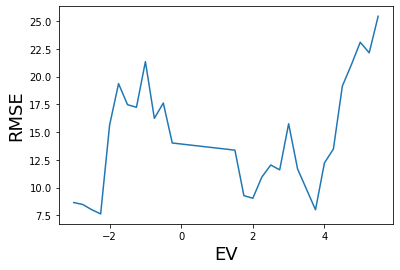

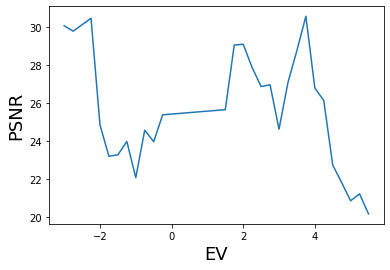

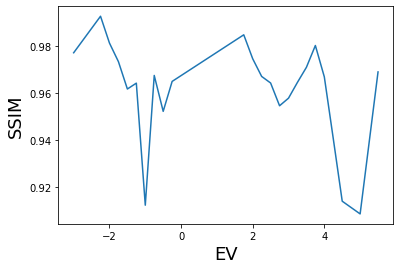

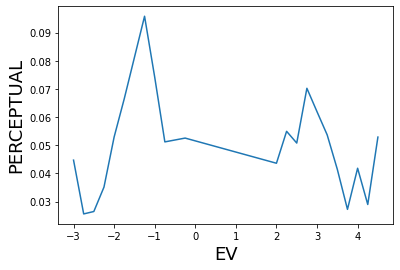

In [20]:
model_by_ev = r.groupby(["metric", "ev"]).describe()["score"]
for metric in ["rmse", "psnr", "ssim", "perceptual"]:
    plt.plot(
        model_by_ev["mean"][metric].index,
        model_by_ev["mean"][metric],
        #         model_by_ev["std"][metric]**2,
    )
    plt.xlabel("EV")
    plt.ylabel(metric.upper())
    plt.savefig(figdir / f"{model_name}_{metric}_by_ev.pdf")
    plt.show()

In [21]:
t2 = get_pred(model_df, df)
t2.nunique()

ev          20
name       724
metric       4
score     2896
dtype: int64

In [22]:
t2.groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.060782,0.025369
psnr,24.124724,3.460552
rmse,17.163110,6.930864
ssim,0.943308,0.034106


In [23]:
t2.groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.060782,0.025369
psnr,24.124724,3.460552
rmse,17.163110,6.930864
ssim,0.943308,0.034106


In [24]:
r.groupby("metric").describe()["score"][["mean", "std"]]

,mean,std
metric,,
perceptual,0.041459,0.024615
psnr,27.417547,3.655543
rmse,11.895489,5.473352
ssim,0.966996,0.020137


In [25]:
from dhdrnet.gen_pairs import GenAllPairs

gen = GenAllPairs(raw_path=DATA_DIR / "dngs", out_path=DATA_DIR)

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


Loading model from: /home/shane/.cache/pypoetry/virtualenvs/dhdrnet-CxDQYEDG-py3.8/lib/python3.8/site-packages/lpips/weights/v0.1/alex.pth


In [26]:
sample = r[r["metric"] == "rmse"].sample(n=100)
sample

,ev,name,metric,score
458324,4.50,0039_20141010_172604_711,rmse,13.298329
140404,-2.75,33TJ_20150811_151236_997,rmse,8.481505
359820,4.00,1125_20160306_143519_230,rmse,11.364781
181984,4.25,5a9e_20150328_170812_096,rmse,13.740078
248784,3.25,33TJ_20150810_194922_367,rmse,9.144555
...,...,...,...,...
165700,3.50,6G7M_20150328_173054_283,rmse,5.899454
246772,3.50,1125_20151220_210945_932,rmse,10.033743
352348,5.00,0830_20151107_133225_793,rmse,23.094608
32792,3.75,0919_20150907_114317_968,rmse,6.283550


<Figure size 432x288 with 0 Axes>

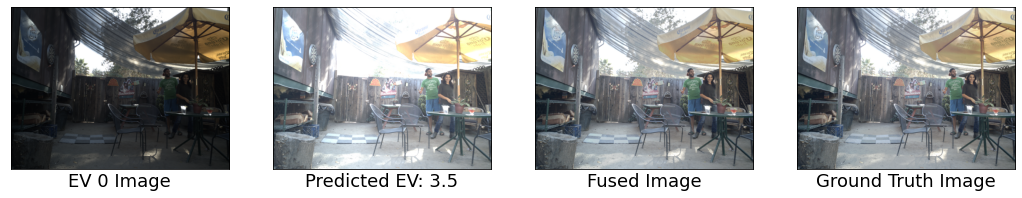

<Figure size 432x288 with 0 Axes>

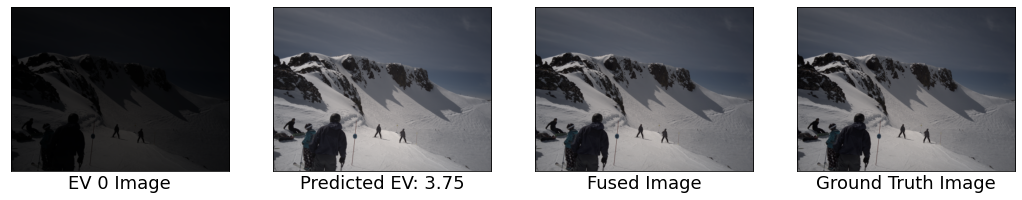

<Figure size 432x288 with 0 Axes>

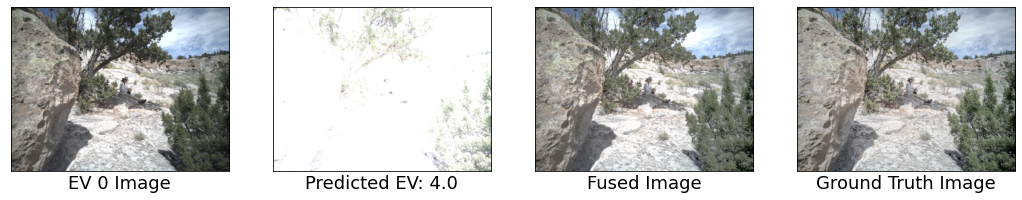

<Figure size 432x288 with 0 Axes>

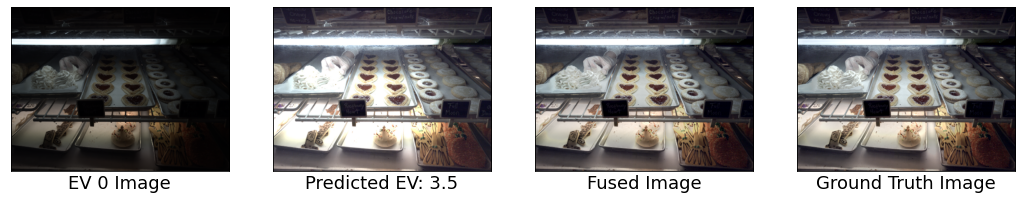

In [27]:
for _i, (ev, name, _, score) in r[r["metric"] == "rmse"].sample(n=4).iterrows():
    plt.clf()
    baseline_img, pred_img = gen.get_exposures(name, [0.0, ev])
    gt_img = gen.get_ground_truth(name)
    fused_img = gen.get_fused(name, [0.0, ev])
    plt.tight_layout()
    fig, axs = plt.subplots(1, 4, figsize=(18, 6))
    for ax in axs:
        ax.set_xticks([])
        ax.set_yticks([])
    axs[0].imshow(baseline_img[..., [2, 1, 0]])
    axs[0].set_xlabel("EV 0 Image")

    axs[1].imshow(pred_img[..., [2, 1, 0]])
    axs[1].set_xlabel(f"Predicted EV: {ev}")

    axs[2].imshow(fused_img[..., [2, 1, 0]])
    axs[2].set_xlabel("Fused Image")

    axs[3].imshow(gt_img[..., [2, 1, 0]])
    axs[3].set_xlabel("Ground Truth Image")

#     plt.savefig(
#         figdir / "predictions" / f"{name}_predictions.png",
#         bbox_inches="tight",
#         transparent="True",
#         pad_inches=0,
#     )
    plt.show()